# Description
The notations of the parameters used in this notebook are as followed:
- raw_df      = imported dataset
- data        = gathered samples
- target      = labels regarding each data
- scaled_data = Standardized data
- x_train     = data used for training the model
- y_train     = targets used for training the model
- x_test      = data used to test the model
- y_test      = targets used to test the model
- y_pred      = predicted targets by the model

# Parameter Selection

In [1]:
classification_mode = 42
# 1: for Logistic regression
    # 11: for from scratch code
    # 12: for scikit-learn code
# 2: for Decision Trees
    # 21: for from scratch code
    # 22: for scikit-Learn code
# 3: for Ensemble Learning
    # 31: for from scratch 
        # 311: for Random Forest Classifier
        # 312: for AdaBoost Classifier
    # 32: for scikit-learn code
        # 321: for Random Forest Classifier
        # 322: for AdaBoost Classifier
        # 323: for Bagging Classifier
        # 324: for Voting Classifier
    # 33: for XGBoost    
# 4: for K-Nearest Neighbor
    # 41: for from scratch code
    # 42: for scikit-learn code
# 5: for Neural Network
    # 51: for from scratch code
    # 52: for Tensorflow code
    # 53: for PyTorch code
# 6: for SVM
    # 62: for scikit-Learn code

dataset = 2
# 1: for breast cancer
# 2: for IRIS
# 3: for Numbers Handwriting


# Load Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score

# Load Dataset and Primary Data Preparation

In [3]:
if dataset == 1:
    from sklearn.datasets import load_breast_cancer
    raw_df_tmp = load_breast_cancer()
    raw_df = pd.DataFrame(raw_df_tmp.data, columns=raw_df_tmp.feature_names)
    raw_df["Cancer Type"]=raw_df_tmp.target
    data_end_index=-2
    data=raw_df.iloc[:,0:data_end_index+1]
    target=raw_df.iloc[:,-1]
elif dataset == 2:
    from sklearn.datasets import load_iris
    raw_df_tmp = load_iris()
    raw_df = pd.DataFrame(raw_df_tmp.data, columns=raw_df_tmp.feature_names)
    raw_df["IRIS Type"]=raw_df_tmp.target
    data_end_index=-2
    data=raw_df.iloc[:,0:data_end_index+1]
    target=raw_df.iloc[:,-1]
elif dataset == 3:
    import requests
    from io import BytesIO
    file_url1 = "https://raw.githubusercontent.com/mghadian/Machine-Learning/main/Handwriting_X.npy"
    file_url2 = "https://raw.githubusercontent.com/mghadian/Machine-Learning/main/Handwriting_y.npy"
    response = requests.get(file_url1)
    data = np.load(BytesIO(response.content), allow_pickle=True)
    response = requests.get(file_url2)
    target = np.load(BytesIO(response.content), allow_pickle=True)

# Data Preparation

## Data Normalization

In [4]:
# Standardizing the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Visualization

In [5]:
if dataset == 3:
    m, n = data.shape
    fig, axes = plt.subplots(8,8,figsize=(8,8))
    fig.tight_layout(pad=0.1)
    for i,ax in enumerate(axes.flat):
        random_index = np.random.randint(m)
        X_random_reshaped = data[random_index].reshape((20,20)).T
        ax.imshow(X_random_reshaped, cmap='gray')
        ax.set_title(target[random_index,0])
        ax.set_axis_off()
else:
    raw_df

# Creation of Training & Test Data

In [6]:
x_train,x_test,y_train,y_test=train_test_split(scaled_data,target,test_size=0.3, random_state=42)

# Classification

## Logistic regression

In [7]:
if classification_mode == 1:
    print('Please define `from scratch` implementation or `scikit-learn` implimentation') 
    print('by using 11 or 12 for `classification_mode` parameter in the `parameter selection` cell')

### From scratch

In [8]:
if classification_mode == 11:
    class LogisticRegression:
        def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-4, verbose=False):
            self.learning_rate = learning_rate
            self.max_iter = max_iter
            self.tol = tol
            self.verbose = verbose
        
        def _softmax(self, z):
            exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        def _cross_entropy_loss(self, y_true, y_pred):
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        def _one_hot_encode(self, y):
            n_classes = len(self.classes_)
            return np.eye(n_classes)[y]
        
        def fit(self, X, y):        
            # Get unique classes and setup
            self.classes_ = np.unique(y)
            n_classes = len(self.classes_)
            n_samples, n_features = X.shape

            self.weights = np.zeros((n_classes, n_features))
            self.bias = np.zeros(n_classes)
            
            # Convert y to one-hot encoding
            y_encoded = self._one_hot_encode(np.searchsorted(self.classes_, y))
            
            prev_loss = float('inf')
            
            for i in range(self.max_iter):
                # Forward pass
                logits = np.dot(X, self.weights.T) + self.bias
                probabilities = self._softmax(logits)
                
                # Calculate loss
                loss = self._cross_entropy_loss(y_encoded, probabilities)
                
                if self.verbose and i % 100 == 0:
                    print(f"Iteration {i}, Loss: {loss}")
                
                # Check for convergence
                if abs(prev_loss - loss) < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {i}")
                    break
                prev_loss = loss
                
                # Backward pass
                gradient = probabilities - y_encoded
                dw = np.dot(gradient.T, X) / n_samples
                db = np.mean(gradient, axis=0)
                
                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
        
        def predict_proba(self, X):
            logits = np.dot(X, self.weights.T) + self.bias
            return self._softmax(logits)
        
        def predict(self, X):
            proba = self.predict_proba(X)
            return self.classes_[np.argmax(proba, axis=1)]
    
    cls = LogisticRegression(verbose=True)

### Using Scikit-Learn

In [9]:
if classification_mode == 12:
    from sklearn.linear_model import LogisticRegression
    cls=LogisticRegression()

## Decision Trees

In [10]:
if classification_mode == 2:
    print('Please define `from scratch` implementation or `scikit-learn` implimentation') 
    print('by using 22 or 22 for `classification_mode` parameter in the `parameter selection` cell')

#### From Scratch

In [11]:
if classification_mode == 21:
    from collections import Counter
    
    class DecisionTreeClassifier:
        def __init__(self, max_depth=None, min_samples_split=2):
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.tree = None
        
        def _entropy(self, y):
            counts = np.bincount(y)
            probabilities = counts / len(y)
            return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        
        def _information_gain(self, X, y, feature_idx, threshold):
            # Split data
            left_mask = X[:, feature_idx] <= threshold
            right_mask = ~left_mask
            
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                return 0
            
            # Calculate child entropies
            n = len(y)
            n_left, n_right = np.sum(left_mask), np.sum(right_mask)
            e_left, e_right = self._entropy(y[left_mask]), self._entropy(y[right_mask])
            child_entropy = (n_left / n) * e_left + (n_right / n) * e_right
            
            # Calculate information gain
            return self._entropy(y) - child_entropy
        
        def _best_split(self, X, y):
            best_gain = -1
            best_feature, best_threshold = None, None
            
            for feature_idx in range(X.shape[1]):
                thresholds = np.unique(X[:, feature_idx])
                for threshold in thresholds:
                    gain = self._information_gain(X, y, feature_idx, threshold)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_idx
                        best_threshold = threshold
                        
            return best_feature, best_threshold
        
        def _build_tree(self, X, y, depth=0):
            self.classes_ = np.unique(y)
            n_samples, n_features = X.shape
            n_classes = len(self.classes_)
            
            # Stopping criteria
            if (depth == self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
                return Counter(y).most_common(1)[0][0]
            
            # Find best split
            feature_idx, threshold = self._best_split(X, y)
            
            if feature_idx is None:  # No split improves purity
                return Counter(y).most_common(1)[0][0]
            
            # Recursive split
            left_mask = X[:, feature_idx] <= threshold
            right_mask = ~left_mask
            
            left_subtree = self._build_tree(X[left_mask], y[left_mask], depth+1)
            right_subtree = self._build_tree(X[right_mask], y[right_mask], depth+1)
            
            return (feature_idx, threshold, left_subtree, right_subtree)
        
        def fit(self, X, y):
            self.tree = self._build_tree(X, y)
        
        def _predict_sample(self, x, node):
            if isinstance(node, (int, np.integer)):  # Leaf node
                return node
            
            feature_idx, threshold, left, right = node
            if x[feature_idx] <= threshold:
                return self._predict_sample(x, left)
            else:
                return self._predict_sample(x, right)
        
        def predict(self, X):
            return np.array([self._predict_sample(x, self.tree) for x in X])
            
    cls = DecisionTreeClassifier(max_depth=3)

#### Using Scikit-Learn

In [12]:
if classification_mode == 22:
    from sklearn.tree import DecisionTreeClassifier, plot_tree
    cls = DecisionTreeClassifier(max_depth=3, random_state=42)

## Ensemble Learning

### From Scratch
#### Random Forest Classifier

In [13]:
if classification_mode == 311:
    import numpy as np
    from sklearn.tree import DecisionTreeClassifier
    
    class RandomForestClassifier:
        def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt', random_state=None):
            self.n_estimators = n_estimators
            self.max_depth = max_depth
            self.max_features = max_features
            self.random_state = random_state
            self.trees = []
            
        def _bootstrap_sample(self, X, y):
            n_samples = X.shape[0]
            idxs = np.random.RandomState(self.random_state).choice(n_samples, n_samples, replace=True)
            return X[idxs], y[idxs]
        
        def fit(self, X, y):
            # Convert to numpy arrays if they're pandas objects
            if hasattr(X, 'values'):
                X = X.values
            if hasattr(y, 'values'):
                y = y.values
                
            self.trees = []
            n_features = X.shape[1]
            
            if self.max_features == 'sqrt':
                max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                max_features = int(np.log2(n_features))
            else:
                max_features = n_features
            
            for i in range(self.n_estimators):
                tree = DecisionTreeClassifier( max_depth=self.max_depth, max_features=max_features,
                    random_state=self.random_state + i if self.random_state is not None else None
                )
                X_sample, y_sample = self._bootstrap_sample(X, y)
                tree.fit(X_sample, y_sample)
                self.trees.append(tree)
        
        def predict(self, X):
            # Convert to numpy if it's a pandas object
            if hasattr(X, 'values'):
                X = X.values
                
            tree_preds = np.array([tree.predict(X) for tree in self.trees])
            return np.array([np.bincount(tree_preds[:,i]).argmax() for i in range(X.shape[0])])
            
    cls = RandomForestClassifier(n_estimators=50, max_depth=3)


#### AdaBoost Classifier 

In [14]:
if classification_mode == 312:
    from sklearn.tree import DecisionTreeClassifier
    class AdaBoostClassifier:
        def __init__(self, n_estimators=50):
            self.n_estimators = n_estimators
            self.models = []
            self.alphas = []
            self.classes_ = None
    
        def fit(self, X, y):
            self.classes_ = np.unique(y)
            n_classes = len(self.classes_)
            n_samples = X.shape[0]
            w = np.ones(n_samples) / n_samples
    
            for _ in range(self.n_estimators):
                # Fit a weak learner (decision stump)
                tree = DecisionTreeClassifier(max_depth=1)
                tree.fit(X, y, sample_weight=w)
                pred = tree.predict(X)
    
                # Compute weighted error
                incorrect = (pred != y)
                err = np.sum(w * incorrect) / np.sum(w)
    
                # Compute alpha
                alpha = np.log((1 - err) / (err + 1e-10)) + np.log(n_classes - 1)
    
                # Update weights
                w *= np.exp(alpha * incorrect)
                w /= np.sum(w)
    
                self.models.append(tree)
                self.alphas.append(alpha)
    
        def predict(self, X):
            n_samples = X.shape[0]
            n_classes = len(self.classes_)
            scores = np.zeros((n_samples, n_classes))
    
            # Weighted vote for each class
            for alpha, model in zip(self.alphas, self.models):
                pred = model.predict(X)
                for i, c in enumerate(self.classes_):
                    scores[:, i] += alpha * (pred == c)
    
            # Return class with highest score
            return self.classes_[np.argmax(scores, axis=1)]

    cls = AdaBoostClassifier(n_estimators=50)


### Using Scikit-Learn

In [15]:
if classification_mode == 321:
    from sklearn.ensemble import RandomForestClassifier
    cls = RandomForestClassifier(n_estimators=100, max_depth=5)
elif classification_mode == 322:
    from sklearn.ensemble import AdaBoostClassifier
    cls = AdaBoostClassifier(n_estimators=100)
elif classification_mode == 323:
    from sklearn.ensemble import BaggingClassifier
    from sklearn.tree import DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier(max_depth=5)
    cls = BaggingClassifier(estimator=dt_clf, n_estimators=100, max_samples=0.8, bootstrap=True)
elif classification_mode == 324:
    from sklearn.ensemble import VotingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier(max_depth=5)
    log_clf = LogisticRegression(max_iter=1000)
    svm_clf = SVC(probability=True)
    cls = VotingClassifier(estimators=[ ('lr', log_clf), ('svc', svm_clf), ('dt', dt_clf)], voting='hard')

### XGBoost

In [16]:
if classification_mode == 33:
    from xgboost import XGBClassifier
    cls = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

## K-Nearest Neighbors (K-NN)
### From scratch

In [17]:
if classification_mode == 41:
    from collections import Counter
    
    class KNNClassifier:
        def __init__(self, k=5):
            self.k = k
            self.X_train = None
            self.y_train = None
        
        def fit(self, X, y):
            # Convert to numpy arrays if they're pandas objects
            self.X_train = np.array(X)
            self.y_train = np.array(y)
        
        def predict(self, X):
            X = np.array(X)
            predictions = [self._predict(x) for x in X]
            return np.array(predictions)
        
        def _predict(self, x):
            # Compute distances (Euclidean)
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            
            # Get indices of k nearest neighbors
            k_indices = np.argpartition(distances, self.k)[:self.k]
            
            # Get labels of these neighbors
            k_nearest_labels = self.y_train[k_indices]
            
            # Return most common class label
            most_common = Counter(k_nearest_labels).most_common(1)
            return most_common[0][0]
            
    cls = KNNClassifier(k=3)

### Using Scikit-Learn

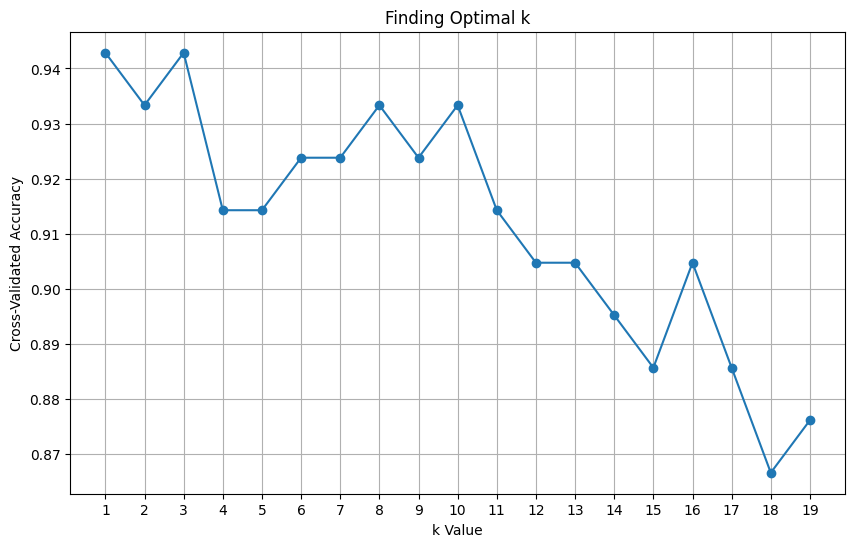

Optimal k value: 1


In [18]:
if classification_mode == 42:
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score
    
    # Find best k
    k_values = range(1, 20)
    cv_scores = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # Plot accuracy vs k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, cv_scores, marker='o')
    plt.xlabel('k Value')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('Finding Optimal k')
    plt.xticks(k_values)
    plt.grid()
    plt.show()
    
    best_k = k_values[np.argmax(cv_scores)]
    print(f"Optimal k value: {best_k}")
    
    cls = KNeighborsClassifier(n_neighbors=best_k)

## Neural Network
For production use, the TensorFlow/Keras implementation is recommended due to its simplicity and optimization. The from-scratch version helps understand fundamentals, while PyTorch offers more flexibility for research.
### From Scratch

In [19]:
if classification_mode == 51:
    from sklearn.preprocessing import OneHotEncoder
    
    class NeuralNetwork:
        def __init__(self, input_size, hidden_size, output_size):
            # Weight initialization
            self.W1 = np.random.randn(input_size, hidden_size) * 0.01
            self.b1 = np.zeros((1, hidden_size))
            self.W2 = np.random.randn(hidden_size, output_size) * 0.01
            self.b2 = np.zeros((1, output_size))
        
        def sigmoid(self, x):
            return 1 / (1 + np.exp(-x))
        
        def softmax(self, x):
            exps = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)
        
        def forward(self, X):
            self.z1 = np.dot(X, self.W1) + self.b1
            self.a1 = np.tanh(self.z1)
            self.z2 = np.dot(self.a1, self.W2) + self.b2
            self.a2 = self.softmax(self.z2)
            return self.a2
        
        def backward(self, X, y, output, learning_rate):
            m = y.shape[0]
            dz2 = output - y
            dW2 = (1/m) * np.dot(self.a1.T, dz2)
            db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
            dz1 = np.dot(dz2, self.W2.T) * (1 - np.power(self.a1, 2))
            dW1 = (1/m) * np.dot(X.T, dz1)
            db1 = (1/m) * np.sum(dz1, axis=0)
            
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
        
        def fit(self, X, y, epochs=1000, learning_rate=0.01):
            y = np.array(y).reshape(-1, 1)
            # Convert y to one-hot encoding if needed
            if len(y.shape) == 1 or y.shape[1] == 1:
                encoder = OneHotEncoder(sparse_output=False)
                y_encoded = encoder.fit_transform(y.reshape(-1, 1))
            else:
                y_encoded = y
                
            for i in range(epochs):
                output = self.forward(X)
                self.backward(X, y_encoded, output, learning_rate)
                if i % 100 == 0:
                    loss = self.cross_entropy_loss(y_encoded, output)
                    print(f"Epoch {i}, Loss: {loss:.4f}")
        
        def cross_entropy_loss(self, y_true, y_pred):
            m = y_true.shape[0]
            loss = -np.sum(y_true * np.log(y_pred + 1e-10)) / m
            return loss
        
        def predict(self, X):
            return np.argmax(self.forward(X), axis=1)
    
    input_size = x_train.shape[1]
    hidden_size = 10
    output_size = len(np.unique(y_train))
    cls = NeuralNetwork(input_size, hidden_size, output_size)
    

### Using Tensorflow
Since this is one of the most prefered models for classification, it is enhanced using fine tuning as well.

In [20]:
if classification_mode == 52:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.layers import Dense, Dropout, Input
    from tensorflow.keras.models import Sequential
    import keras_tuner as kt
    
    def build_flexible_nn(hp):
        model = Sequential()
        model.add(Input(shape=(x_train.shape[1],)))
        
        # Input layer
        model.add(Dense(units=hp.Int('input_units', 128, 1024, step=128), activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001)))
        model.add(Dropout(0.3))
        
        # Hidden layers
        for i in range(hp.Int('n_layers', 1, 4)):
            model.add(Dense(units=hp.Int(f'hidden_{i}_units', 64, 512, step=64), activation=hp.Choice(f'act_{i}', ['relu', 'tanh', 'elu']),
                kernel_regularizer=keras.regularizers.l2(0.001)))
            model.add(Dropout(0.3))
        
        # Output layer
        n_classes = len(np.unique(y_train))
        model.add(Dense(n_classes, activation='softmax' if n_classes > 2 else 'sigmoid'))
        
        # Compile
        optimizer = keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log'), weight_decay=1e-4)
        model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])
        return model
    
    tuner = kt.RandomSearch( build_flexible_nn, objective='val_accuracy', max_trials=15, executions_per_trial=1,
        directory='nn_tuning', project_name='flexible_nn', overwrite=True)
    
    # Add validation split
    x_train_tune, x_val, y_train_tune, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
    tuner.search(x_train_tune, y_train_tune, epochs=50, validation_data=(x_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), tf.keras.callbacks.TerminateOnNaN()], verbose=1)
    
    # Get the BEST trained model
    cls = tuner.get_best_models(num_models=1)[0]

### Using PyTorch

In [21]:
if classification_mode == 53:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

    class NeuralNet(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.BatchNorm1d(hidden_size),  # batch normalization
                nn.ReLU(),
                nn.Dropout(0.3),             # Regularization
                nn.Linear(hidden_size, num_classes)
            )
            self.optimizer = optim.Adam(self.parameters(), lr=0.001)
            self.criterion = nn.CrossEntropyLoss()
        
        def forward(self, x):
            return self.net(x)
        
        def fit(self, X, y, epochs=20, batch_size=64):

            # Convert to numpy arrays if they're pandas objects
            X = X.values if hasattr(X, 'values') else np.array(X)
            y = y.values if hasattr(y, 'values') else np.array(y)
            
            # Ensure y is 1D class indices (0-9)
            if y.ndim > 1:  # If one-hot encoded
                y = np.argmax(y, axis=1)
            y = y.astype(np.int64).reshape(-1)  # Ensure 1D integer array
    
            # Convert to tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.LongTensor(y)
            
            # Create DataLoader
            dataset = TensorDataset(X_tensor, y_tensor)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
            # Training loop
            self.train()
            for epoch in range(epochs):
                for batch_X, batch_y in loader:
                    self.optimizer.zero_grad()
                    outputs = self(batch_X)
                    loss = self.criterion(outputs, batch_y)
                    loss.backward()
                    self.optimizer.step()
                
                # Print progress
                if (epoch+1) % 5 == 0:
                    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
        
        def predict(self, X):
            self.eval()  # Set to evaluation mode
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X)
                outputs = self(X_tensor)
                return torch.argmax(outputs, dim=1).numpy()


    input_size = x_train.shape[1]
    hidden_size = 256
    num_classes = len(np.unique(y_train))
    
    cls = NeuralNet(input_size, hidden_size, num_classes)

## SVM
### Using Scikit Learn

In [22]:
if classification_mode == 62:
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['linear', 'rbf', 'poly']}
    
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
    grid.fit(x_train, y_train)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best accuracy: {grid.best_score_:.2f}")
    cls = grid.best_estimator_

## Training the model
The model should have `n_class x n_features` weights.

In [23]:
cls.fit(x_train, y_train)
if classification_mode == 11:
    print('The optimized weights of Logistic Regression are: ',cls.weights)
elif classification_mode == 12:
    print('The optimized weights of Logistic Regression are: ',cls.coef_)
elif classification_mode == 321 or classification_mode == 322 or classification_mode == 22:
    from sklearn.tree import plot_tree
    importances = cls.feature_importances_
    features = pd.DataFrame({'Feature': raw_df_tmp.feature_names,'Importance': importances}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(10,6))
    plt.barh(features['Feature'], features['Importance'])
    plt.title("Feature Importances")
    plt.show()   
    if classification_mode == 22:
        from sklearn.tree import plot_tree
        plt.figure(figsize=(12,8))
        plot_tree(cls, filled=True, feature_names=raw_df_tmp.feature_names, class_names=raw_df_tmp.feature_names)
        plt.title("Decision Tree Visualization")
        plt.show()        
elif classification_mode == 52:
    print("Model Summary:")
    cls.summary()

y_pred = cls.predict(x_test)
if classification_mode == 52:
    if len(np.unique(y_train)) == 2:
        y_pred = (y_pred > 0.5).astype(int)
    else:
        y_pred = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test


# Performance Analysis

Multiclass Accuracy: 0.9777777777777777
Confusion Matrix:
[[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



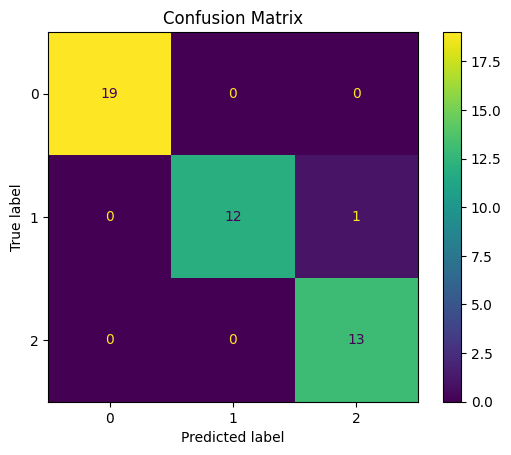

In [24]:
print(f"Multiclass Accuracy: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()